In [1]:
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.utils import shuffle

import pandas as pd
import numpy as np

import pickle

import random
from sklearn.metrics.pairwise import euclidean_distances

import numpy as np
from sklearn.decomposition import PCA

In [2]:
from model_fit_functions import calculate_reconstr_loss_pca_tau, rescale_back
from data_load import load_split_pool

In [3]:
from model_fit_functions import dump_object

In [25]:
# Load data
directory_list = ['./data/']
data_dict =  load_split_pool(1346, 430, 10, scale = False, take_log = True, directory_list = directory_list)

# Pooled X data
train_df_pooled = data_dict["x_pooled"]["train"]
val_df_pooled = data_dict["x_pooled"]["val"]

Directory: ./data/ Physical properties shape: (2156, 5) Spectral prop shape: (2156, 110001)
Spectral data shape (2156, 110001)
Physical data shape (2156, 5)


In [13]:
data_dict.keys()

dict_keys(['x', 'x_pooled', 'y', 'parameters', 'wavelengths'])

In [24]:
data_dict["x_pooled"]["val"]

,0,1,2,3,4,5,6,7,8,9,...,10991,10992,10993,10994,10995,10996,10997,10998,10999,11000
0,-0.261725,-0.452267,1.140954,1.363089,-1.654396,1.447690,-0.027496,0.899347,0.788919,-0.316874,...,0.783853,-0.922220,-0.809217,0.452159,1.128638,-1.643977,1.671632,0.439653,1.402640,-0.131205
1,-0.308742,1.278384,-0.164257,0.423641,-0.925619,2.138461,-0.139614,-2.459442,-0.458937,0.731117,...,-1.510462,-1.208887,0.794462,-0.432361,1.411682,0.879757,-0.362473,-1.266781,0.630467,-1.179472
2,0.787641,0.579387,-0.576880,-0.466008,-0.764366,0.891138,-1.470187,0.857359,-0.094512,-2.093791,...,0.566391,-1.182059,0.194154,1.002556,-1.420636,1.528686,-0.514753,0.853640,0.605525,1.334512
3,0.479718,-0.037415,-0.787147,0.575379,-0.132575,-0.917425,0.113505,0.180280,0.304748,-0.634584,...,-0.518988,-2.691128,-0.034486,-0.558620,-0.473542,1.007500,-1.691567,-0.877696,-0.365114,0.435146
4,0.121239,0.828071,-0.722794,0.498755,1.147220,-0.777277,0.262013,0.119812,-0.189020,0.111844,...,1.523959,-0.848940,0.576777,-0.138432,1.201143,0.171689,-0.480796,-0.153023,0.384069,-0.953567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,0.047078,-1.418437,-1.618868,-1.538063,-1.001459,0.427354,-1.342271,-1.474734,-0.237448,-0.544546,...,0.116119,0.007400,0.354135,-1.437082,0.446700,0.495073,-0.521104,1.178329,-0.341259,-1.057599
426,-0.886843,0.228595,0.435293,0.186362,-0.968384,-0.572528,1.491291,-1.518188,-0.619075,-1.441261,...,-1.004401,0.821680,-0.253034,0.005282,-0.956320,0.497714,0.136117,1.418922,-1.213933,-1.037034
427,0.028027,1.455767,-0.392682,2.107264,-0.397313,2.170282,-1.371076,-0.549702,0.470086,1.326953,...,-0.641880,-0.961819,-1.577985,-1.103819,-0.375256,-1.063107,0.349854,-0.725187,0.935387,0.939323
428,0.675879,1.139785,-0.227954,0.714606,0.730075,-0.236688,1.180011,-0.377444,-2.330169,-0.245842,...,0.479082,-0.444309,-0.071059,-0.399628,0.154800,1.420768,-0.362462,-0.483165,0.611117,-0.037678


### PCA

In [26]:
n_comp_list_pca = list( np.arange(1, 100, 2) )

In [27]:
pca_results_dict = dict()

In [28]:
# Fit PCA

pca = PCA(n_components=250)
pca.fit(train_df_pooled)
x_train_pca = pca.transform(train_df_pooled)
x_val_pca = pca.transform(val_df_pooled)


pca_results_dict["object"] = pca
pca_results_dict["x_train_input"] = train_df_pooled
pca_results_dict["x_val_input"] = val_df_pooled

pca_results_dict["x_train_transformed"] = x_train_pca
pca_results_dict["x_val_transformed"] = x_val_pca

# Reconstruction loss

In [29]:
pca_results_dict["restricted_spaces"] = dict()

pca_loss_list = []
dist_mean_pca = []
dist_std_pca = []

for n_comp in n_comp_list_pca:
    
    x_val_pca, x_val_original_space_pca, pca_loss = calculate_reconstr_loss_pca_tau(pca, val_df_pooled, n_comp, 
                              rescale = False,
                             mean = data_dict["parameters"]["mean"],
                             std = data_dict["parameters"]["std"])
    
    pca_results_dict["restricted_spaces"][n_comp] = dict()
    pca_results_dict["restricted_spaces"][n_comp]["x_val_transformed"] = x_val_pca
    pca_results_dict["restricted_spaces"][n_comp]["x_val_original_space_pca"] = x_val_original_space_pca
    pca_results_dict["restricted_spaces"][n_comp]["loss"] = pca_loss
    
    pca_loss_list.append(pca_loss)
    
pca_results_dict["loss"] = pca_loss

Text(0.5, 0, 'Number of components')

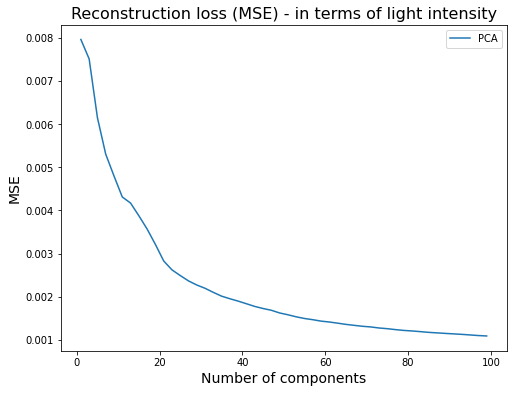

In [30]:
fig, ax = plt.subplots(figsize = (8,6))
ax.plot( np.array(n_comp_list_pca), np.array(pca_loss_list) , label = "PCA")

ax.legend()
ax.set_title("Reconstruction loss (MSE) - in terms of light intensity", fontsize = 16)
ax.set_ylabel("MSE", fontsize = 14)
ax.set_xlabel("Number of components", fontsize = 14)

In [31]:
pca_tau_loss = dict()
pca_tau_loss["loss"] = pca_loss_list
pca_tau_loss["ncomps"] = n_comp_list_pca

In [34]:
# Save the object (commented out to prevent overwriting)
location = './outputs'
filename = "pca_tau_try"
dump_object(pca_results_dict, location, filename)

()

# Signal reconstruction

In [ ]:
random.seed(2324)
random_number = random.sample(range(val_df_pooled.shape[0]), 1, )
number_of_elements = 20

In [ ]:
random_number

[275]

In [ ]:
n_comp = 50

In [ ]:
val_projected_pca, val_original_space_proj_pca, loss_pca = calculate_reconstr_loss_pca_tau(pca, val_df_pooled, n_comp,
                             rescale = False,
                             mean = data_dict["parameters"]["mean"],
                             std = data_dict["parameters"]["std"])

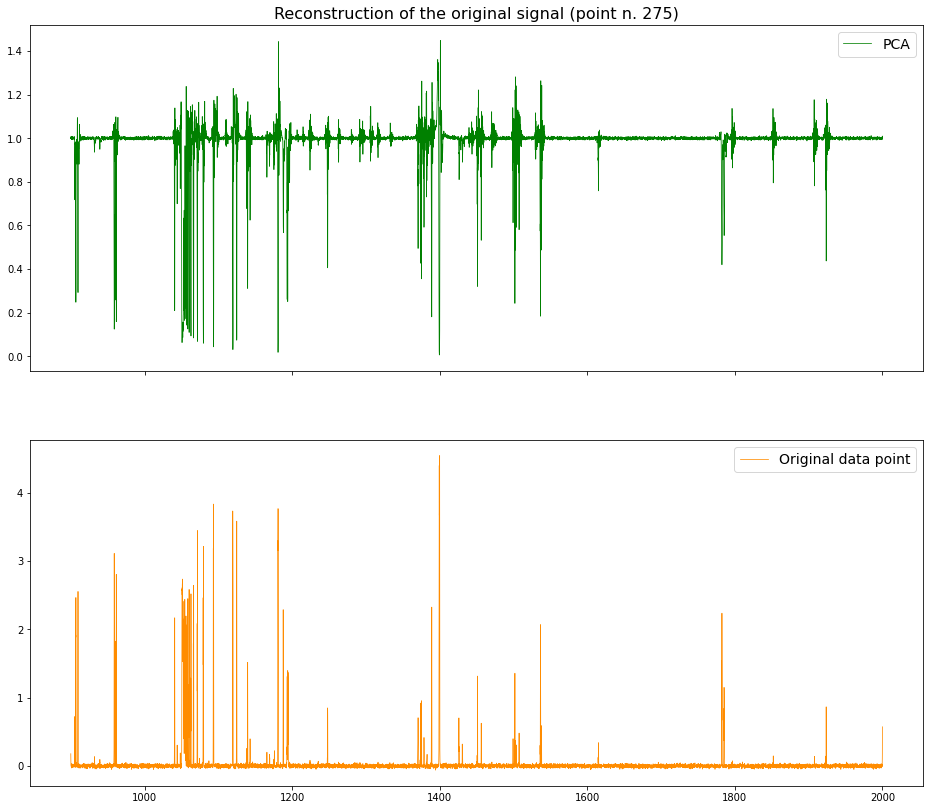

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex = True, figsize = (16, 14))

ax[0].plot(data_dict["wavelengths"], val_original_space_proj_pca[random_number,:][0], label = "PCA", linewidth = 0.75, color = "green")
ax[0].legend(fontsize = 14)

ax[1].plot(data_dict["wavelengths"], val_df_pooled[random_number,:][0], label = "Original data point", linewidth = 0.75, color = "darkorange")
ax[1].legend(fontsize = 14)

ax[0].set_title("Reconstruction of the original signal (point n. " + str(random_number[0]) + ")",
               fontsize = (16));